# Plot of the eddy coefficients

In [14]:
import numpy as np  # http://www.numpy.org
import matplotlib.pyplot as plt   # http://matplotlib.org
import math as M  # https://docs.python.org/2/library/math.html
from sympy.solvers import solve
from sympy import Symbol
from scipy.optimize import fsolve
from scipy.integrate import odeint

In [15]:
#### Constants #####
L_x = 1000000 #zonal extent [m]
L_y = 2000000 #meridional extent [m]
A = L_x*L_y #surface area of interior [m^2] Note that the interior is probably smaller than this
P = 2*L_x+2*L_y #Perimeter [m]

g = 9.81 #gravitational acceleration [m/s^2]
C_p = 3994 #specific heat capacity of sea water [J/(kg C)] source: Steffie's paper
alpha_T = 0.2 #thermal expansion coefficient [kg m^-3 C^-1] source: Steffie's paper
alpha_S = 0.8 #Haline expansion coefficient [kg m^-3 g^(-1) kg]
c = 0.006 #bottom slope coefficient
s = 0.02 #average bottom slope around the perimeter of the marginal sea
S = 35 #reference salinity [ppt]. Spall [2015]
E = -2e-8 #constant freshwater flux [m/s]
S_1 = 35.2 #from Lambert [g kg^-1]

#### Parameters ####
H = 1000 #sill height [m]
f_0 = 1.2e-4 #Coriolis parameter [s^-1]
Gamma = 20 #Restoring strength [W/(m^2 C)]

L = H/s #width of sloping topography of the boundary current [m]
T_1 = 8.87 #ingoing temperature [Celsius]
T_A = 2.8 #Atmospheric temperature [Celsius]
ro_0 = 1028  #density sea water [kg m^-3]. Range of 7 to 9 degrees of sea water
#h_1 = ... #thickness upper layer [m]

#### functions ####
epsilon = c*P/L #ratio of heat fluxed into interior by eddies compared to heat flux by advection into the basin in the inflowing boundary current [-]
mu = A*Gamma*f_0/(alpha_T*g*C_p*H**2*(T_1-T_A)) #[-]


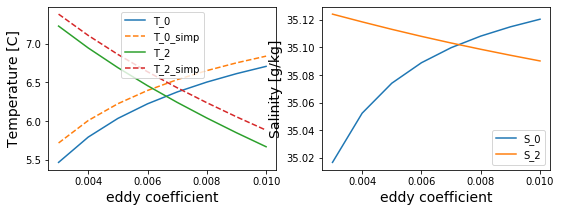

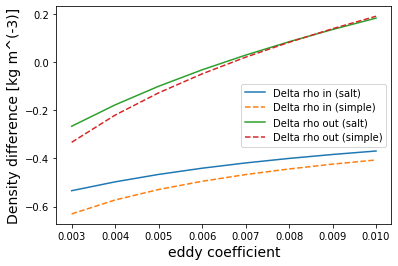

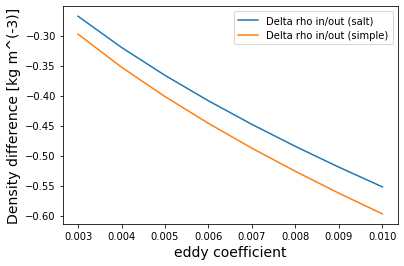

In [41]:
c_array = [0.003,0.004,0.005,0.006, 0.007,0.008,0.009,0.01]

#Salt model
T_0 = np.zeros(len(c_array))
T_2 = np.zeros(len(c_array))
S_0 = np.zeros(len(c_array))
S_2 = np.zeros(len(c_array))

for i in range(len(c_array)):
    c=c_array[i]
    def main(x): # function with seven unkowns:  T_0,  T_2,  S_0,  S_2,  V_1, T_eddy, S_eddy 
                 #                              x[0], x[1], x[2], x[3], x[4],   x[5],   x[6]
        return [P*H*x[5]-A*Gamma*(x[0]-T_A)/(ro_0*C_p),
                P*H*x[6]+A*E*S,
                (T_1-x[1])*x[4]*H*L-(x[0] - T_A + (P*L/A)*(T_1-T_A))*A*Gamma/(ro_0*C_p),
                (S_1-x[3])*x[4]*H*L+E*A*S+P*L*E*S,
                g*H/(2*ro_0*f_0*L)*(alpha_T*(T_1-x[0])-alpha_S*(S_1-x[2]))-x[4],
                c*x[4]*(T_1-x[0])-x[5],
                c*x[4]*(S_1-x[2])-x[6]]
    [T_0[i],T_2[i],S_0[i],S_2[i],V_1,T_eddy,S_eddy] = fsolve(main, [1,1,1,1,1,1,1])

#Simple model
T_0_simp = np.zeros(len(c_array))
T_out_simp = np.zeros(len(c_array))

for i in range(len(c_array)):
    T_0_simp[i] = T_1 - (mu)/(c_array[i]*P/L)*(M.sqrt(1+2*(c_array[i]*P/L)/mu)-1)*(T_1 - T_A)
    T_out_simp[i] = T_1 - 2*mu*((T_1-T_A)/(T_1-T_0_simp[i])*(1+P*L/A)-1)*(T_1-T_A)

#Density salinity model
Delta_ro_in = np.zeros(len(c_array))
Delta_ro_out = np.zeros(len(c_array))
ro_in_ro_out = np.zeros(len(c_array))

for i in range(len(c_array)):
    Delta_ro_in[i] = ((-alpha_T*(T_1-T_0[i]) + alpha_S*(S_1-S_0[i])))
    Delta_ro_out[i] = (-alpha_T*(T_2[i]-T_0[i]) + alpha_S*(S_2[i]-S_0[i]))
    ro_in_ro_out[i] = (-alpha_T*(T_1-T_2[i]) + alpha_S*(S_1-S_2[i]))
    
#Density simple model
Delta_ro_in_simp = np.zeros(len(c_array))
Delta_ro_out_simp = np.zeros(len(c_array))
ro_in_ro_out_simp = np.zeros(len(c_array))

for i in range(len(c_array)):
    Delta_ro_in_simp[i] = -alpha_T*(T_1 - T_0_simp[i]) #(rho1-rho0)
    Delta_ro_out_simp[i] = -alpha_T*(T_out_simp[i]-T_0_simp[i])
    ro_in_ro_out_simp[i] = (-alpha_T*(T_1-T_out_simp[i]))

#Plotting                                               
plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.plot(c_array, T_0, label='T_0')
plt.plot(c_array, T_0_simp, '--', label='T_0_simp')
plt.plot(c_array, T_2, label='T_2')
plt.plot(c_array, T_out_simp, '--', label='T_2_simp')
plt.xlabel('eddy coefficient', fontsize=14) # label along x-axes
plt.ylabel('Temperature [C]', fontsize=14) # label along x-axes
plt.legend(loc='best')
plt.subplot(122)
plt.plot(c_array, S_0, label='S_0')
plt.plot(c_array, S_2, label='S_2')
plt.xlabel('eddy coefficient', fontsize=14) # label along x-axes
plt.ylabel('Salinity [g/kg]', fontsize=14) # label along x-axes
plt.legend(loc='best')
plt.show()

#I don't know how these subplots work, it doesn't want to plot 3 subplots
plt.plot(c_array, Delta_ro_in, label='Delta rho in (salt)')
plt.plot(c_array, Delta_ro_in_simp, '--', label= 'Delta rho in (simple)')
plt.plot(c_array, Delta_ro_out, label='Delta rho out (salt)')
plt.plot(c_array, Delta_ro_out_simp, '--', label='Delta rho out (simple)')
plt.xlabel('eddy coefficient', fontsize=14) # label along x-axes
plt.ylabel('Density difference [kg m^(-3)]', fontsize=14) # label along x-axes
plt.legend(loc='best')
plt.show()

plt.plot(c_array, ro_in_ro_out, label='Delta rho in/out (salt)')
plt.plot(c_array,ro_in_ro_out_simp, label='Delta rho in/out (simple)')
plt.xlabel('eddy coefficient', fontsize=14) # label along x-axes
plt.ylabel('Density difference [kg m^(-3)]', fontsize=14) # label along x-axes
plt.legend(loc='best')
plt.show()

Interior temperature of both the models increase with increasing c, which makes sense because more eddy heat flux from the boundary flows into the interior. As a result, the outflowing temperature decreases because more heat is extracted from the boundary current. The same explanation holds for the salinity, although the effect on the outflowing salinity is rather small. A combination of this result can be seen in the density plot, where both the inflowing and outflowing density decrease as a function of increasing c. Rho_in_simp decreases because T_0_simp increases (warmer water -> less dense). The other densities I don't understand yet at first sight. With rho_in one could argue that the effect of warmer water is stronger than the effect of more saline water (which would increase the density). I don't understand why the outflowing densities would decrease? Note that the outflowing water is a function of both T_0 and T_out. This could be the reason why it decreases. Also, why is there a spike in the density for the salinity model?